# Fandango Ratings Analysis

In October 2015 a data journalist found strong evidence that Fandango's (a film rating aggregator) rating system wasn't accurate. The ratings were always rounded up, so if someone rated a film was rated at 4.1 would be rated at 4.5 stars, any film rated at 4.5 was rated at 5 stars etc.

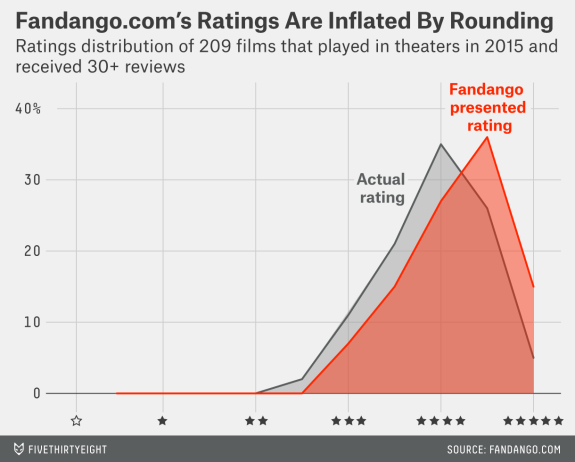

We want to see whether that has been fixed since.

The data originally used by the journalist can be found __[here](https://github.com/fivethirtyeight/data/tree/master/fandango)__

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import percentileofscore
from numpy import arange

fandango = pd.read_csv("fandango_score_comparison.csv")
fandango_new = pd.read_csv("movie_ratings_new.csv")

In [2]:
fandango.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILM                        146 non-null    object 
 1   RottenTomatoes              146 non-null    int64  
 2   RottenTomatoes_User         146 non-null    int64  
 3   Metacritic                  146 non-null    int64  
 4   Metacritic_User             146 non-null    float64
 5   IMDB                        146 non-null    float64
 6   Fandango_Stars              146 non-null    float64
 7   Fandango_Ratingvalue        146 non-null    float64
 8   RT_norm                     146 non-null    float64
 9   RT_user_norm                146 non-null    float64
 10  Metacritic_norm             146 non-null    float64
 11  Metacritic_user_nom         146 non-null    float64
 12  IMDB_norm                   146 non-null    float64
 13  RT_norm_round               146 non

In [3]:
fandango.head(3)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5


In [4]:
fandango_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movie         214 non-null    object 
 1   year          214 non-null    int64  
 2   metascore     214 non-null    int64  
 3   imdb          214 non-null    float64
 4   tmeter        214 non-null    int64  
 5   audience      214 non-null    int64  
 6   fandango      214 non-null    float64
 7   n_metascore   214 non-null    float64
 8   n_imdb        214 non-null    float64
 9   n_tmeter      214 non-null    float64
 10  n_audience    214 non-null    float64
 11  nr_metascore  214 non-null    float64
 12  nr_imdb       214 non-null    float64
 13  nr_tmeter     214 non-null    float64
 14  nr_audience   214 non-null    float64
dtypes: float64(10), int64(4), object(1)
memory usage: 25.2+ KB


In [5]:
fandango_new.head(3)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.5,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.5,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.0,2.35,2.5,3.5,2.0,2.5


Not all the columns in the datasets are of interest to us, so we are just cgoing to select those that give us the information about Fandango's movie ratings, which in this case are:

1. __In the original dataset:__
    - "FILM"
    - "Fandango_Stars"
    - "Fandango_Ratingvalue"
    - "Fandango_votes"
    - "Fandango_Difference"
    <br>
    <br>
2. __In the most current dataset:__
    - "movie"
    - "year"
    - "fandango"

In [6]:
fandango_before = fandango[["FILM","Fandango_Stars", "Fandango_Ratingvalue", "Fandango_votes", "Fandango_Difference"]].copy()
fandango_after = fandango_new[["movie", "year", "fandango"]].copy()

Our goal is to determine whether there has been any change in Fandango's rating system since the article about the dubious reviews system was published. 

In order to do that and to draw an appropriate conclusion we need to sample the population at two different time periods, before the article was written and after, which is why we have the two datasets above. We also need to make sure that our samples are as representative as possible to make sure we can extrapolate the results to the whole website.

## Determining if the sample is big enough

By reading the README available in the repository about the sample used by the journalist, we know that the sample criteria followed was:
- Films need to have at least 30 fan reviews on Fandango's website before Aug. 24, 2015
- The film must have had tickets on sale in 2015

Similarly for the second dataset, the sample criteria was as follows:
- The film must have had a significant number o votees and reviews
- The film must have been released between 2016 and 2017
- The film must have had reviews on Fandnago as of march 22, 2017

Knowing this, we know that the sampling technique was not a random sample instead a purposive sample technique was used for the sampling. As a result, the sample is likely not representative of the whole population we are interested in describing. However, in order to continue with our analysis, we are going to tweak our goal so slightly and find a workaround that is good enough, rather than abandoning the analysis altogether, and the tweaking of the goal is a much easier approach than collecting new data, which would be complicated to do when it comes to data from before the publishing of the article.

Our new goal will be to find out whether there is any difference between Fandango's ratings for popular movies in 2015 and popular movies in 2016.

## Isolating the samples we need

1. All Fandango's ratings for popular films released in 2015
2. All Fandango's ratings for popular films released in 2016

We consider popular films those that have more than 30 reviews on the site. However, our second sample doesn't have the number of ratings of films. To determine if the sample is truly representative and contains popular films, we are going to take a random sample of 10 films and check for the aamount for ratings the films have in Fandango's website. We are hoping for at least 8 out of 10 films from the sample to have more than 30 ratings.

In [7]:
fandango_after.sample(10, random_state = 1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


As of April 2018, these are the fan ratings we found:

| Title | Movie	Fan ratings|
|:----: | :----:           |
| Mechanic: Resurrection | 2247 |
|Warcraft	|7271|
|Max Steel	|493|
|Me Before You|	5263|
|Fantastic Beasts and Where to Find Them|	13400|
|Cell|	17|
|Genius|	127|
|Sully|	11877|
|A Hologram for the King|	500|
|Captain America: Civil War|	35057|

All but one film has more than 30 reviews. This gives us enough confidence to keep moving forward with the analysis.
Just in case, even the documentation for the original dataset already states that the dataset only has popular films we are going to double-check it.

In [8]:
sum(fandango_before["Fandango_votes"]<30)

0

We only want the films that were released in 2015 and 2016. We can see in the datasets that some of them were released in different dates. The original dataset also has the year appended to the FILM title. We are going to extract that year, add it to a new column, and then we'll make sure to filter and only use films that were released on the years that we are interested in.

In [9]:
#To create a new column with the year number
fandango_before["Year"] = (fandango_before["FILM"].str[-5:-1])

In [10]:
fandango_before.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,2015


In [11]:
fandango_before["Year"].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

In [12]:
fandango_2015 = fandango_before[fandango_before["Year"]== "2015"].copy()
fandango_2015["Year"].value_counts()

2015    129
Name: Year, dtype: int64

In [13]:
fandango_after["year"].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [14]:
fandango_2016 = fandango_after[fandango_after["year"]==2016].copy()
fandango_2016["year"].value_counts()

2016    191
Name: year, dtype: int64

## Comparing Distribution Shapes Between Samples

To compare the distribution of the samples, we are going to use kernel density plots.

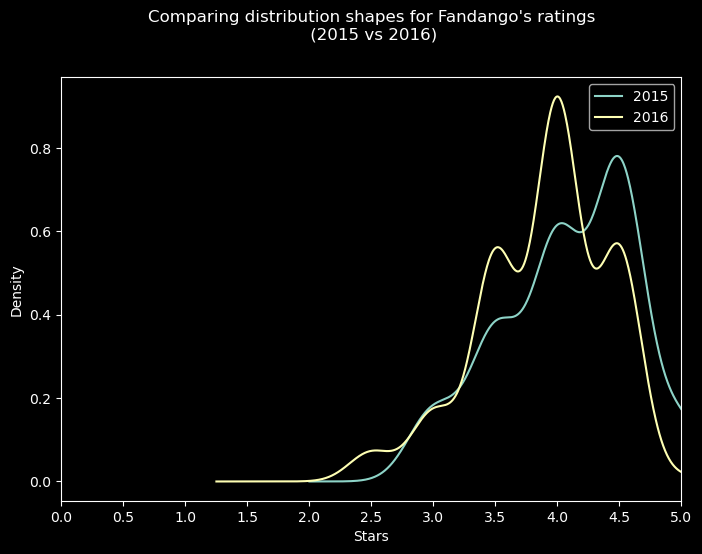

In [22]:
%matplotlib inline

plt.style.use("dark_background")

fandango_2015["Fandango_Stars"].plot.kde(label = "2015", legend =True, figsize = (8,5.5))
fandango_2016["fandango"].plot.kde(label = "2016", legend = True)

plt.title("Comparing distribution shapes for Fandango's ratings\n (2015 vs 2016)", y = 1.07)
plt.xlabel("Stars")
plt.xlim(0,5)
plt.xticks(arange(0,5.1,0.5))
plt.show()

Both distributions are strongly left skewed, with the 2016 one shifted slightly further to the left. This means that the ratings in 2016 were a bit lower than in 2015. It is possible that some change were indeed made then to the ratings.

Let's look at the frequency distribution tables of both datasets. We are going to use relative frequencies because the samples are of different size, and using absolute numbers would not make sense.

In [24]:
print("2015" + "\n" + "-"*16)

fandango_2015["Fandango_Stars"].value_counts(normalize=True).sort_index()*100

2015
----------------


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [25]:
print("2016"+"\n"+"-"*16)

fandango_2016["fandango"].value_counts(normalize=True).sort_index()*100

2016
----------------


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

In 2016 there were less films with higher ratings (4.5 and 5), only 0.5% had 5 stars, while in 2015 the percentage of 5 rated films was 7%.

The minimum rating is also lower in 2016 with 3% vs 8.5% in 2015, showing a clear difference between distributions.

However, for ratings between 3.5 and 4 there were more films in 2016 than in 2015.This challenges the change we had seen in the plots.

## Determining the direction of the change

Let's look at a few more metrics to see if we can determine more precisely the direction of the change. To do that we are going to look for the mean, median, and mode, and then plot the values.

In [31]:
mean_2015 = fandango_2015["Fandango_Stars"].mean()
mean_2016 = fandango_2016["fandango"].mean()

median_2015 = fandango_2015["Fandango_Stars"].median()
median_2016 = fandango_2016["fandango"].median()

mode_2015 = fandango_2015["Fandango_Stars"].mode()[0]
mode_2016 = fandango_2016["fandango"].mode()[0]

summary = pd.DataFrame()
summary["2015"] = [mean_2015, median_2015, mode_2015]
summary["2016"] = [mean_2016, median_2016, mode_2016]
summary.index = ["mean", "median", "mode"]
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


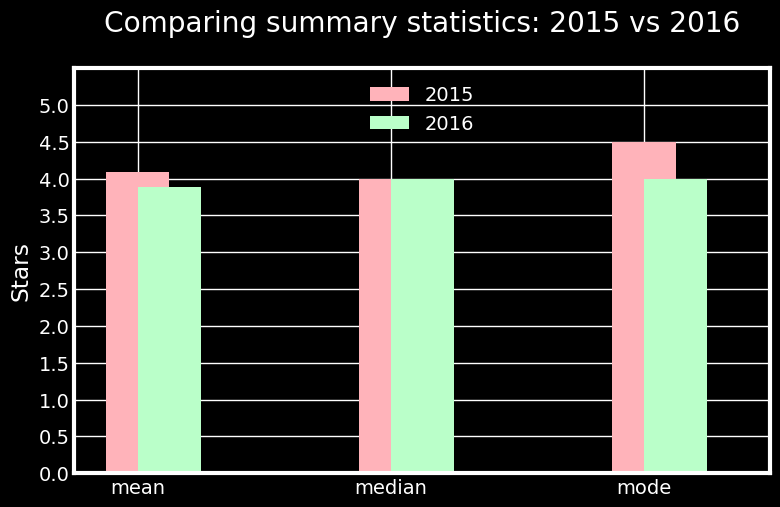

In [50]:
plt.style.use("dark_background")

summary["2015"].plot.bar(color="#ffb3ba", align = "center", label = "2015", width =.25)
summary["2016"].plot.bar(color = "#baffc9", align = "edge", label = "2016", width =.25, figsize = (8,5), rot= 0)

plt.title("Comparing summary statistics: 2015 vs 2016", y=1.07)
plt.ylim(0,5.5)
plt.yticks(arange(0,5.1,.5))
plt.ylabel("Stars")
plt.legend(framealpha = 0,loc = "upper center")
plt.show()

The mean rating in 2016 was lower than in 2015 by approximately 0.2. This means a drop of almost 5% relative to the mean in 2015.

In [51]:
(summary.loc["mean"][0]-summary.loc["mean"][1])/summary.loc["mean"][0]

0.04842683568951993

While the median is the same for both distributions, the mode is lower for 2016 by 0.5. Considering that and what we have seen regarding the mean, the direction fo the change we saw on the kernel density plot is confirmed, meaning that the popular films in 2016 had a slightly lower rating than those in 2015.

## Conclusion

Our analysis has shown that there's indeed a difference between Fandango's ratings in 2015 and in 2016. We are not 100% sure what caused that change, but it is possible that it is due to a change in the ranking system after the data journalist's article was published.